In [ ]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Since Keras does not have a built-in attention layer. We had to import it from a custom attention layer module. "attetion.py" under the project directory.

In [ ]:
from attention import AttentionLayer

## Read cleaned data.

In [ ]:
data=pd.read_csv("/Users/codyyu/Desktop/CMPE 297/movies/clean_data_imdb.csv")

In [ ]:
data.shape

(787, 6)

In [ ]:
data

,Name,link,summary,storyline,summary_count,storyline_count
0,The Shawshank Redemption,/title/tt0111161/,two imprison men bond number year find solac eventu redempt act common decenc,chronicl experi formerli success banker prison gloomi jailhous shawshank found guilti crime commit film portray man uniqu way deal hi new tortur life along way befriend number fellow prison notabl...,13,36
1,The Godfather,/title/tt0068646/,age patriarch organ crime dynasti postwar new york citi transfer control hi clandestin empir hi reluct youngest son,godfath vito corleon head corleon mafia famili new york event hi daughter wed michael vito youngest son decor ww ii marin also present wed michael seem uninterest part famili busi vito power man k...,18,71
2,Pulp Fiction,/title/tt0110912/,live two mob hitmen boxer gangster hi wife pair diner bandit intertwin four tale violenc redempt,jule winnfield vincent vega two hit men retriev suitcas stolen employ mob boss marsellu wallac wallac ha also ask vincent take hi wife mia day later wallac town butch coolidg age boxer paid wallac...,16,49
3,The Godfather Part II,/title/tt0071562/,earli life career vito corleon new york citi portray hi son michael expand tighten hi grip famili crime syndic,continu saga corleon crime famili tell stori young vito corleon grow sicili new york follow michael corleon attempt expand famili busi la vega hollywood cuba,19,25
4,Inception,/title/tt1375666/,thief steal corpor secret use dream share technolog given invers task plant idea mind c e hi tragic past may doom pro read,dom cobb skill thief absolut best danger art extract steal valuabl secret deep within subconsci dure dream state mind vulner cobb rare abil ha made covet player thi treacher new world corpor espio...,23,95
...,...,...,...,...,...,...
782,Terminator Salvation,/title/tt0438488/,mysteri new weapon war machin half human half machin come john connor eve resist attack skynet whose side read,longview state correct facil crimin marcu wright death row convinc cancer dr serena kogan donat hi bodi research accept unsuccess attack skynet facil onli john connor surviv discov skynet develop ...,19,93
783,Spider-Man 3,/title/tt0413300/,strang black entiti anoth world bond peter parker caus inner turmoil contend new villain temptat reveng,peter parker ha final manag piec togeth onc broken part hi life maintain balanc hi relationship mari jane hi respons spider man challeng aris young hero peter old friend harri obsourn ha set reven...,16,103
784,Loft,/title/tt1606789/,five best friend marri decid share loft apart carri affair,five best friend marri decid share loft apart thi loft meet mistress conquest everyth seem perfect morn bodi unknown young woman found loft friend begin suspect one anoth soon becom clear know far...,10,37
785,The Descent,/title/tt0435625/,cave expedit goe horribl wrong explor becom trap ultim pursu strang breed predat,woman goe vacat friend husband daughter encount tragic accid one year later goe hike friend get trap cave lack suppli struggl surviv meet strang blood thirsti creatur,13,27


Check if there is null data.

In [ ]:
data.isnull().sum()

Name               0
link               0
summary            0
storyline          0
summary_count      0
storyline_count    0
dtype: int64

Check word count distributions of both story and summary.

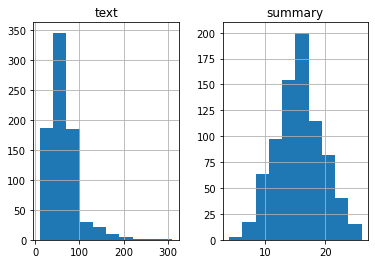

In [ ]:
text_word_count = []
summary_word_count = []

for i in data['storyline']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 10)
plt.show()

Set maximum story length and summary length so that we have a smaller model to build.

In [ ]:
max_text_len=100
max_summary_len=20

In [ ]:
cleaned_text =np.array(data['storyline'])
cleaned_summary=np.array(data['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Now we only have 632 rows of data after filtering.

In [ ]:
df.shape

(632, 2)

Adding start token and end token to the summaries.

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

Split the train/validation data. 9:1.

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

Tokenizinig the data.

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.19243143863949
Total Coverage of rare words: 22.144529519711448


There are way too many rare words in this dataset.

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

Size of vocabulary

In [ ]:
x_voc

1816

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 89.7863818424566
Total Coverage of rare words: 46.560287435274226


The summary data is worse than the storyline text. Almost half of the words are rare words.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(568, 568)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Model Building

Using keras backend with encoding lstm layers and one decoding lstm layer.

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     181600      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

## Model training.

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=25, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/25
18/18 [==============================] - 48s 2s/step - loss: 2.9759 - val_loss: 2.0349
Epoch 2/25
18/18 [==============================] - 38s 2s/step - loss: 2.3269 - val_loss: 1.8700
Epoch 3/25
18/18 [==============================] - 38s 2s/step - loss: 2.2273 - val_loss: 1.7966
Epoch 4/25
18/18 [==============================] - 54s 3s/step - loss: 2.1486 - val_loss: 1.7406
Epoch 5/25
18/18 [==============================] - 41s 2s/step - loss: 2.0986 - val_loss: 1.7230
Epoch 6/25
18/18 [==============================] - 45s 3s/step - loss: 2.0718 - val_loss: 1.7084
Epoch 7/25
18/18 [==============================] - 42s 2s/step - loss: 2.0585 - val_loss: 1.7204
Epoch 8/25
18/18 [==============================] - 45s 3s/step - loss: 2.0365 - val_loss: 1.7243
Epoch 9/25
18/18 [==============================] - 40s 2s/step - loss: 2.0232 - val_loss: 1.7107
Epoch 10/25
18/18 [==============================] - 41s 2s/step - loss: 2.0047 - val_loss: 1.7230
Epoch 11/25
18/18 [

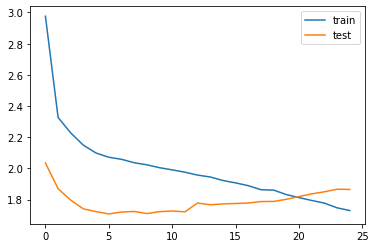

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Gets overfitting around the 20th epoch.

## Testing the trained model.

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Examples:

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: li live life father one day local mobster bison kidnap father mother death embark quest rescu kidnap father power crimin lord bison 
Original summary: teenag wit kidnap father crime goe quest vengeanc becom crime read 
Predicted summary:  two death hi children hi friend death hi death hi death


Review: orphan outcast sinc hi father left hi hunt tribe secret mission grow master hunter put truth first hi chanc win statu charm girl thu fall hi rival buddi coupl among captiv taken ride slave hunter take charg epic rescu mission follow way build site live god win support peopl impress way thank tooth onc save secretli slave rise hi peopl 
Original summary: past bond beauti warrior must embark save read 
Predicted summary:  two young travel travel travel girlfriend hi girlfriend hi girlfriend


Review: motorcycl tale father son thi stori smoke also known king presid motorcycl club whose member african american men white worker exchang suit night weekend motorcycl focu thi stori take

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
